## Load libraries

In [4]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from vae_utils import VAEUtils
import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Load a model

In [5]:
vae = VAEUtils(directory='/Users/asa279/Desktop/MyGitHub/chemical_vae/examples/zinc_properties')

Using standarized functions? True
Standarization: estimating mu and std values ...done!


# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

In [15]:
smiles_1 = mu.canon_smiles('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

Input                : Cn1c(=O)c2c(ncn2C)n(C)c1=O
Reconstruction       : Nc1c(=O)c2c(ncn2F)n(C)c1=O
Z representation     : (1, 196) with norm 13.020


## property preditor

In [16]:
print('Properties (qed,SAS,logP):')
y_1 = vae.predict_prop_Z(z_1)[0]
print(y_1)

Properties (qed,SAS,logP):
[ 0.6544234   2.822336   -0.96482587]


## Decode several attempts
VAE are probabilistic

Searching molecules randomly sampled from 35.00 std (z-distance) from the point
Found 9 unique mols, out of 83
SMILES
 0    Cn1c(=O)c2c(ncn2C)n(C)c1=O
1    Cn1c(=O)c2c(cnn2C)n(C)c1=O
2    Cn1c(=O)c2c(ncn2F)n(C)c1=O
3    Cn1c(=O)c2c(cnn2F)n(C)c1=O
4    Cn1c(=O)c2c(ccn2C)n(C)c1=O
5    Cn1c(=O)c2c(ncnc2)n(C)c1=O
6    Cn1c(=O)c2c(cnnc2)n(C)c1=O
7    Cn1c(=O)c2c(ncn2)nn(C)c1=O
8    Cn1c(=O)c2c(ncn2)/c(C)c1=O
Name: smiles, dtype: object


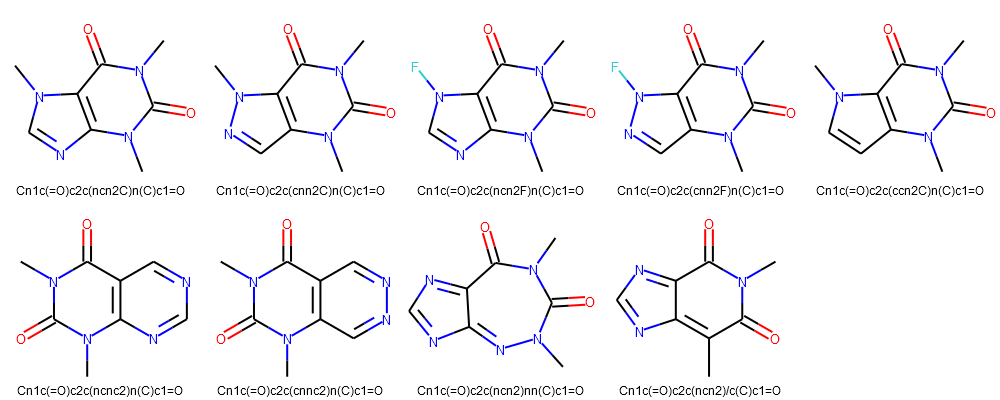

,smiles,distance,count,frequency,mol
0,Cn1c(=O)c2c(ncn2C)n(C)c1=O,0.000004,55,0.662651,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,Cn1c(=O)c2c(cnn2C)n(C)c1=O,3.155053,1,0.012048,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,Cn1c(=O)c2c(ncn2F)n(C)c1=O,3.276226,14,0.168675,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,Cn1c(=O)c2c(cnn2F)n(C)c1=O,3.464364,1,0.012048,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,Cn1c(=O)c2c(ccn2C)n(C)c1=O,4.115365,1,0.012048,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [23]:
noise=35.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=100,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

## PCA: latent space

Sample random points from the training set along with properties

In [13]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,167710,2.47852,0.678237,2.233968,COc1ccccc1NS(=O)(=O)c1ccc(Cc2cc(C)n[nH]c2=O)cc1
1,161311,1.66950,0.746465,3.748317,COc1ccc(OC(C)C)c(NC(=O)N[C@@H]2CC[C@@H]([NH+](...
2,108785,3.39020,0.740622,3.435690,CSCc1ccnc(N(C)Cc2[nH]cc(-c3ccccc3)[nH+]2)c1
3,147833,1.11772,0.856259,3.518504,Cc1occc1C(=O)NC1CC[NH+](CN2Cc3ccc(F)cc3C2=O)CC1
4,243050,2.43400,0.940651,2.715553,C[C@@H](Cn1cccn1)NC(=O)N1CCCc2ccccc21


Perform a PCA projection and color the points based on a property

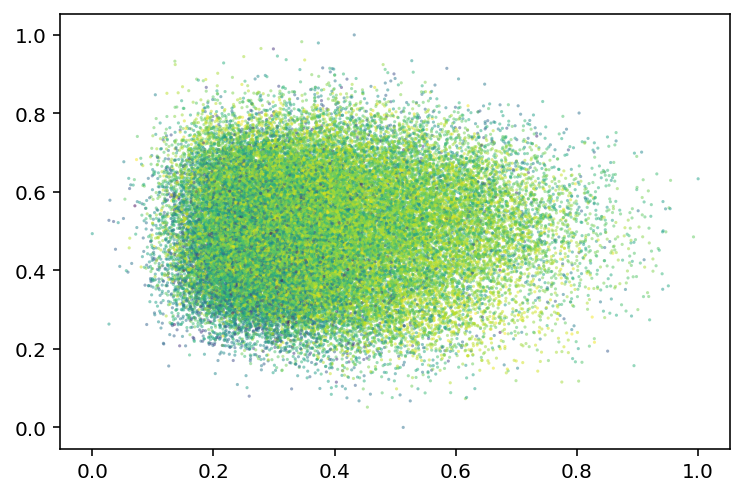

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

compare with t-SNE, will take some time

In [ ]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

f = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()